In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

In [2]:
data_train_path = 'dataset_gambar/train'
data_test_path = 'dataset_gambar/test'
data_val_path = 'dataset_gambar/valid'

In [3]:
img_width = 180
img_height = 180 

In [4]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_width, img_height),
    batch_size=32
)

data_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    image_size=(img_width, img_height),
    batch_size=32,
    shuffle=False
)

data_test = tf.keras.utils.image_dataset_from_directory(
    data_test_path,
    image_size=(img_height,img_width),
    shuffle=False,
    batch_size=32,
)

Found 5199 files belonging to 13 classes.
Using 4160 files for training.
Found 650 files belonging to 13 classes.
Found 650 files belonging to 13 classes.


In [5]:
data_cat = data_train.class_names

In [6]:
data_cat

['Ayam Goreng',
 'Burger',
 'French Fries',
 'Gado-Gado',
 'Ikan Goreng',
 'Mie Goreng',
 'Nasi Goreng',
 'Nasi Padang',
 'Pizza',
 'Rawon',
 'Rendang',
 'Sate',
 'Soto']

In [7]:
normalization_layer = layers.Rescaling(1./255)

data_train = data_train.map(lambda x, y: (normalization_layer(x), y))
data_val = data_val.map(lambda x, y: (normalization_layer(x), y))
data_test = data_test.map(lambda x, y: (normalization_layer(x), y))

In [8]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])
data_train = data_train.map(lambda x, y: (data_augmentation(x), y))

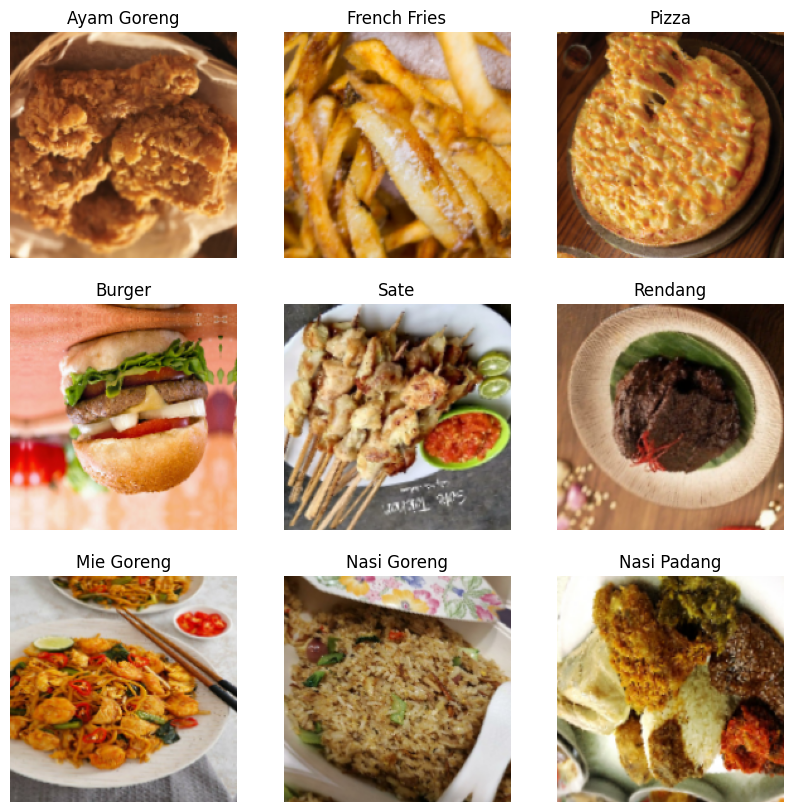

In [9]:
plt.figure(figsize=(10,10))
for image, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow((image[i].numpy() * 255).astype("uint8"))
        plt.title(data_cat[labels[i]])
        plt.axis('off')
plt.show()

In [10]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False  # Freeze pre-trained layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(data_cat), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)   

C:\Users\joshu\AppData\Local\Temp\ipykernel_23596\3154374375.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))


In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

epochs_size = 100
history = model.fit(
    data_train,
    validation_data=data_val,
    epochs=epochs_size,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 169ms/step - accuracy: 0.1537 - loss: 2.7738 - val_accuracy: 0.4508 - val_loss: 1.8254 - learning_rate: 1.0000e-04
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.3781 - loss: 1.9030 - val_accuracy: 0.6262 - val_loss: 1.3188 - learning_rate: 1.0000e-04
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 181ms/step - accuracy: 0.5373 - loss: 1.4684 - val_accuracy: 0.6862 - val_loss: 1.0921 - learning_rate: 1.0000e-04
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 184ms/step - accuracy: 0.5811 - loss: 1.3024 - val_accuracy: 0.7308 - val_loss: 0.9500 - learning_rate: 1.0000e-04
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 180ms/step - accuracy: 0.6264 - loss: 1.1658 - val_accuracy: 0.7415 - val_loss: 0.8737 - learning_rate: 1.0000e-04
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 180ms/step - accuracy: 0.6562 - loss: 1.0772 - val_accuracy: 0.7646 - val_loss: 0.8273 - learning_rate: 1.0000e-04
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


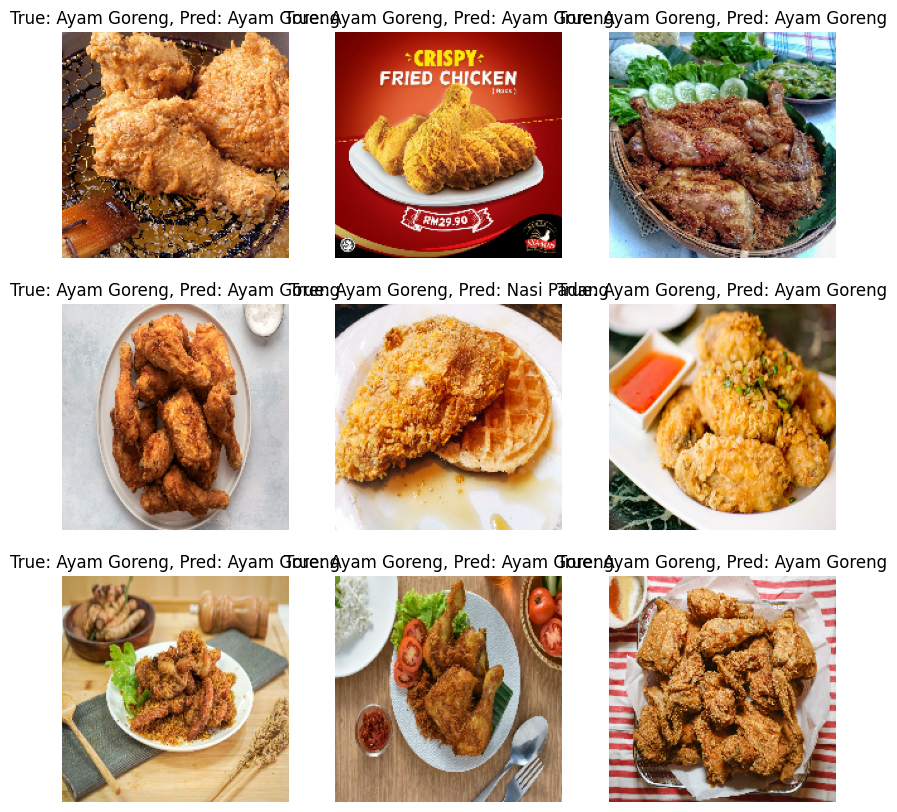

In [13]:
for images, labels in data_val.take(1):
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(f"True: {data_cat[labels[i]]}, Pred: {data_cat[pred_classes[i]]}")
        plt.axis("off")
    plt.show()

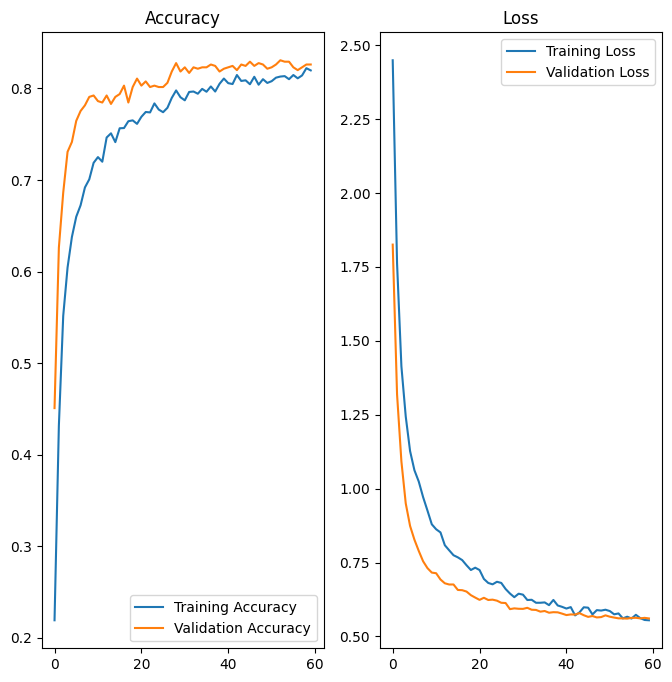

In [14]:
epochs_range = range(len(history.history['accuracy']))
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,history.history['accuracy'],label = 'Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'],label = 'Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,history.history['loss'],label = 'Training Loss')
plt.plot(epochs_range, history.history['val_loss'],label = 'Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [35]:
image = 'testimg/soto1.webp'
image = tf.keras.utils.load_img(image, target_size=(img_height, img_width))
img_arr = tf.keras.utils.img_to_array(image)
img_bat = tf.expand_dims(img_arr, 0) / 255.0  # Normalize

predict = model.predict(img_bat)
score = tf.nn.softmax(predict[0])

print(f"Food in image is {data_cat[np.argmax(score)]} with accuracy of {np.max(score) * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Food in image is Soto with accuracy of 18.02%


In [17]:
model.save('Image_classify.keras')